In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from diagnostics.inventory import ModelInventoryBuilder, QueryBuilder

In [2]:
# prompt to specify directory containing config files
artifacts_path  = input("Please enter path to artifacts, no quotation marks: ")
print("Searching for models in %s" % artifacts_path)
assert os.path.isdir(artifacts_path)


Searching for models in /Users/danbiderman/Dropbox/Columbia/1.Dan/Research/grid_artifacts


Steps:
1. load our hydra cfg (start with 1 and extend)
2. flatten hierarchy.
3. make into a df (optionally append more).
4. build queries.


In [3]:
model_inventory = ModelInventoryBuilder(artifacts_path)

In [4]:
total_df = model_inventory.build_dframe()

Building model registry from 101 configs...


100%|██████████| 101/101 [00:01<00:00, 75.76it/s]


In [5]:
query_builder = QueryBuilder(total_df)
query_builder.add_query("training.rng_seed_data_pt", "in", ["0", "1","2"])
query_builder.add_query("training.train_frames", "==", "75") # # use just training.train_frames=1 for now
# query_builder.add_query("model.losses_to_use", "==", "[]") # works
# query_builder.add_query("model.losses_to_use", "==", "['unimodal_mse']") # works
query_builder.add_query("model.losses_to_use", "in", ["[]", "[unimodal_mse]"]) # trying to grab both unimodal_mse and supervised. note no quotes inside brackets per loss
query_builder.add_timestamp_query("2022-11-16", "2022-11-17") # works
print(query_builder.combine_queries("and"))

`training.rng_seed_data_pt` == '0' or `training.rng_seed_data_pt` == '1' or `training.rng_seed_data_pt` == '2'
`model.losses_to_use` == '[]' or `model.losses_to_use` == '[unimodal_mse]'
(`training.rng_seed_data_pt` == '0' or `training.rng_seed_data_pt` == '1' or `training.rng_seed_data_pt` == '2') and (`training.train_frames` == '75') and (`model.losses_to_use` == '[]' or `model.losses_to_use` == '[unimodal_mse]') and (timestamp >= '2022-11-16' and timestamp <= '2022-11-17')


In [6]:
total_df_queried = total_df.query(query_builder.combine_queries("and"))
total_df_queried.shape

(3, 96)

In [7]:
# for supervised models we should set the log weights, for plotting, for all losses, to be zero.

In [24]:
def load_pred_csvs(filename, metric_name, split_set, pd_kwrgs) -> pd.DataFrame:
    df = pd.read_csv(filename, **pd_kwrgs)
    # take mean over all columns that are not "set"
    df["mean"] =  df.loc[:,[c for c in df.columns if c!= "set"]].mean(axis=1)
    if split_set is not None:
        df["set"] = split_set
    # add mean and metric
    df["metric"] = metric_name
    
    return df

In [25]:
# df = pd.read_csv(filename, header=[0], index_col=[0])
# print(df.columns)
# print(df["set"])
#  df.loc[:,[c for c in df.columns if c!= "yearID"]]
# [col is not "set" for col in df.columns.to_list()]

In [26]:
# loop over rows of df, load predictions_pixel_error.csv, predictions_pca_singleview_error.csv
df_list = []
loss_log_weights = total_df.columns[total_df.columns.str.contains("losses") & total_df.columns.str.contains("log_weight")].to_list()
for i, path in enumerate(total_df_queried["path"]):

    df_metric_list = []
    for metric_name in ["pixel_error", "pca_singleview_error", "pca_multiview_error"]:
        filename = os.path.join(path, "predictions_%s.csv" % metric_name)
        if os.path.isfile(filename):
            df = load_pred_csvs(filename, metric_name, None, pd_kwrgs={"header": [0], "index_col": 0})
            df_metric_list.append(df)
    
    df_ = pd.concat(df_metric_list) # concat to one df

    # add path
    df_["path"] = path
    # add rng_seed_data_pt
    df_["rng_seed_data_pt"] = total_df_queried.iloc[i]["training.rng_seed_data_pt"]

    # add log weight for all losses
    for log_weight in loss_log_weights:
        if  total_df_queried.iloc[i]["model.losses_to_use"] == "[]":
            df_[log_weight] = "100" # for supervised model, actually infinity
        else: 
            df_[log_weight] = total_df_queried.iloc[i][log_weight]

    df_list.append(df_)

# concat all dfs
df_big = pd.concat(df_list)


In [27]:
df_big["set"]

labeled-data/180605_000/img023761.png        unused
labeled-data/180605_000/img025996.png        unused
labeled-data/180605_000/img037515.png        unused
labeled-data/180605_000/img042413.png        unused
labeled-data/180605_000/img048598.png         train
                                            ...    
labeled-data/180618_010/img015138.png        unused
labeled-data/180618_010/img015239.png    validation
labeled-data/180618_010/img015255.png        unused
labeled-data/180618_010/img015256.png         train
labeled-data/180618_010/img015397.png        unused
Name: set, Length: 7101, dtype: object

In [28]:
df_big.shape

(7101, 28)

In [29]:
df_big.columns[df_big.columns.str.contains("losses")]

Index(['losses.pca_multiview.log_weight', 'losses.pca_singleview.log_weight',
       'losses.temporal.log_weight', 'losses.unimodal_mse.log_weight',
       'losses.unimodal_kl.log_weight', 'losses.unimodal_js.log_weight'],
      dtype='object')

In [30]:
# values = df_big["unimodal_mse_log_weight"].unique()
# # sort values by magnitude 
# values = sorted(values, key=lambda x: float(x))
# values

In [31]:
# input which hparam to sweep -- which log weight
hparam_name = input("Select hparam to sweep, e.g. losses.pca_multiview.log_weight (no quotes): ")
# input split set
split_set = input("Select split set, e.g. train, validation, test (no quotes): ")
# input dataset name
dataset_name = input("Select dataset name, e.g. mirror-mouse (no quotes): ")
# accordingly, get values and sort them and plot all existing metrics
values = df_big[hparam_name].unique()
values = sorted(values, key=lambda x: float(x))



In [32]:
print(hparam_name)
print(split_set)
print(dataset_name)
print(values)
# dataset_name = "mirror-mouse"
# sweep_name = "unimodal_mse"
# split_set = "validation"

losses.pca_multiview.log_weight
validation
mirror-mouse
['100']


In [33]:
df_big

,paw1LH_top,paw2LF_top,paw3RF_top,paw4RH_top,tailBase_top,tailMid_top,nose_top,obs_top,paw1LH_bot,paw2LF_bot,...,mean,metric,path,rng_seed_data_pt,losses.pca_multiview.log_weight,losses.pca_singleview.log_weight,losses.temporal.log_weight,losses.unimodal_mse.log_weight,losses.unimodal_kl.log_weight,losses.unimodal_js.log_weight
labeled-data/180605_000/img023761.png,0.577913,1.994983,8.525753,7.600343,NaN,NaN,3.329281,1.921803,3.844057,5.003783,...,5.654901,pixel_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,1,100,100,100,100,100,100
labeled-data/180605_000/img025996.png,26.026342,7.535127,8.774785,2.609687,3.291989,NaN,3.577381,2.496166,1.814963,4.666238,...,6.301870,pixel_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,1,100,100,100,100,100,100
labeled-data/180605_000/img037515.png,8.360441,5.986607,10.150717,4.841003,NaN,2.177224,2.519282,1.450521,5.322374,2.875786,...,22.276141,pixel_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,1,100,100,100,100,100,100
labeled-data/180605_000/img042413.png,5.919042,117.616368,1.855256,5.545206,3.054684,1.992272,3.645214,2.538938,6.308999,3.049851,...,10.711248,pixel_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,1,100,100,100,100,100,100
labeled-data/180605_000/img048598.png,3.312439,3.552347,3.360529,2.978710,5.225495,4.472129,3.852309,1.801551,2.830352,2.926577,...,3.477089,pixel_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,1,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
labeled-data/180618_010/img015138.png,4.076916,2.502631,2.038859,0.337894,2.145605,9.001984,1.645638,NaN,4.350002,2.670255,...,3.211124,pca_multiview_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,0,100,100,100,100,100,100
labeled-data/180618_010/img015239.png,1.414462,0.172432,0.862190,1.213068,5.881368,0.509029,1.019827,NaN,1.509202,0.183988,...,1.634742,pca_multiview_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,0,100,100,100,100,100,100
labeled-data/180618_010/img015255.png,2.999637,0.050589,0.658029,3.679713,1.839562,5.176452,1.161508,NaN,3.200538,0.053972,...,2.298104,pca_multiview_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,0,100,100,100,100,100,100
labeled-data/180618_010/img015256.png,24.629963,0.253375,0.961183,4.089900,2.674807,4.921772,1.014416,NaN,26.279621,0.270350,...,5.690895,pca_multiview_error,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...,0,100,100,100,100,100,100


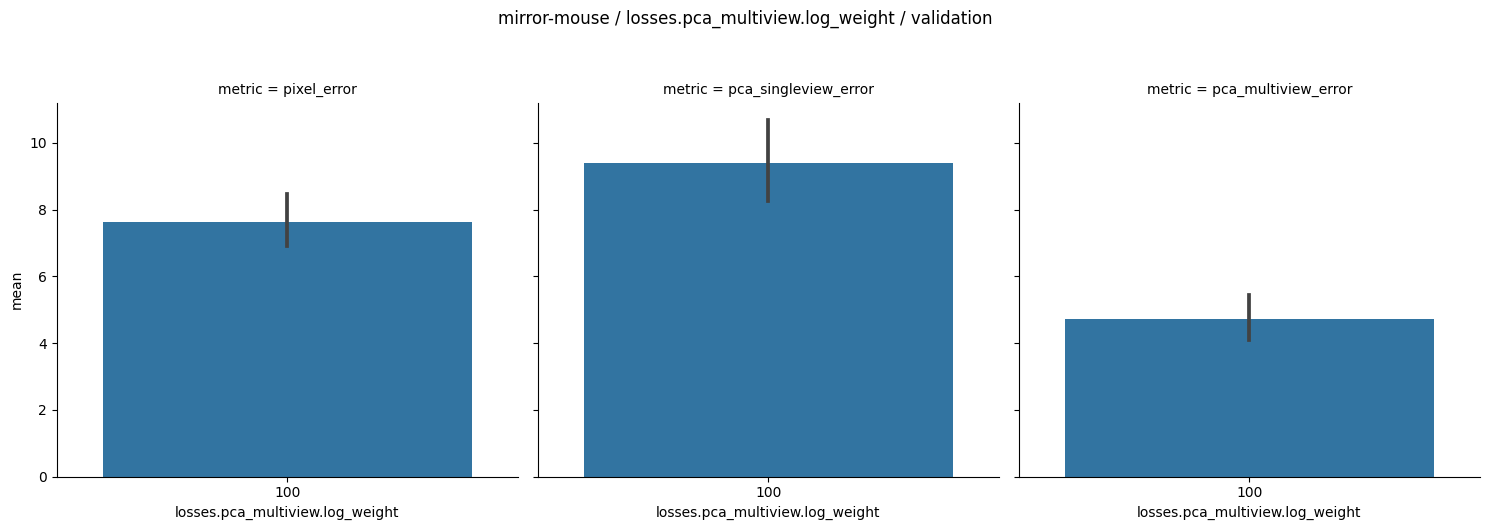

In [35]:
# plot bars with errors per rng seed, and two panels, one per metric
# sns.catplot(data=df_big_mean, x="rng_seed_data_pt", y="paw1LH_top", col="metric", ci="sd")

g = sns.catplot(data=df_big[df_big["set"] == split_set], x=hparam_name, order=values, y="mean", col="metric", errorbar=('ci', 95), kind="bar") # x="unimodal_mse_log_weight"
# add dataset name and sweep and split set to title
g.fig.suptitle(f"{dataset_name} / {hparam_name} / {split_set}", y=1.05)
g.fig.tight_layout()
# add horizontal line at 5 
# plt.axhline(y=5, color='r', linestyle='-')

In [36]:
df_big.columns

Index(['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top',
       'tailMid_top', 'nose_top', 'obs_top', 'paw1LH_bot', 'paw2LF_bot',
       'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot', 'tailMid_bot', 'nose_bot',
       'obsHigh_bot', 'obsLow_bot', 'set', 'mean', 'metric', 'path',
       'rng_seed_data_pt', 'losses.pca_multiview.log_weight',
       'losses.pca_singleview.log_weight', 'losses.temporal.log_weight',
       'losses.unimodal_mse.log_weight', 'losses.unimodal_kl.log_weight',
       'losses.unimodal_js.log_weight'],
      dtype='object')

In [37]:
df_big["set"]

labeled-data/180605_000/img023761.png        unused
labeled-data/180605_000/img025996.png        unused
labeled-data/180605_000/img037515.png        unused
labeled-data/180605_000/img042413.png        unused
labeled-data/180605_000/img048598.png         train
                                            ...    
labeled-data/180618_010/img015138.png        unused
labeled-data/180618_010/img015239.png    validation
labeled-data/180618_010/img015255.png        unused
labeled-data/180618_010/img015256.png         train
labeled-data/180618_010/img015397.png        unused
Name: set, Length: 7101, dtype: object

In [40]:
# grouping by rng_seed_data_pt and hparam_name and metric, and then taking mean and std
df_big_mean = df_big.groupby(["rng_seed_data_pt", hparam_name, "metric", "set"]).mean().reset_index()
df_big_mean

/var/folders/xs/19x2cmc95hz0kl_cxbgd4bnh0000gn/T/ipykernel_914/3189459955.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_big_mean = df_big.groupby(["rng_seed_data_pt", hparam_name, "metric", "set"]).mean().reset_index()


,rng_seed_data_pt,losses.pca_multiview.log_weight,metric,set,paw1LH_top,paw2LF_top,paw3RF_top,paw4RH_top,tailBase_top,tailMid_top,...,paw1LH_bot,paw2LF_bot,paw3RF_bot,paw4RH_bot,tailBase_bot,tailMid_bot,nose_bot,obsHigh_bot,obsLow_bot,mean
0,0,100,pca_multiview_error,test,3.712051,4.409332,4.075005,3.331602,2.708597,8.970800,...,3.960681,4.704661,4.347946,3.554749,2.890013,9.571650,1.210408,NaN,NaN,4.184423
1,0,100,pca_multiview_error,train,1.926259,1.588717,1.007825,1.949151,2.804873,7.375113,...,2.055275,1.695134,1.075329,2.079703,2.992740,7.869092,1.225886,NaN,NaN,2.628145
2,0,100,pca_multiview_error,unused,4.957799,3.370309,2.204200,4.022996,3.190693,9.291641,...,5.289865,3.596047,2.351834,4.292452,3.404399,9.913981,1.211875,NaN,NaN,4.159564
3,0,100,pca_multiview_error,validation,5.857632,4.760218,3.446916,3.021885,2.622938,4.921148,...,6.249969,5.079049,3.677783,3.224288,2.798618,5.250760,1.207691,NaN,NaN,3.803627
4,0,100,pca_singleview_error,test,6.713250,7.291964,11.446131,6.640156,7.988902,12.411662,...,5.675675,9.969574,8.453413,6.684000,6.960510,8.239163,4.114680,NaN,NaN,7.754580
5,0,100,pca_singleview_error,train,3.952556,4.116597,6.383559,4.595715,7.359695,10.247956,...,3.337498,6.694920,4.874624,4.507441,5.110457,6.847441,3.742473,NaN,NaN,5.509686
6,0,100,pca_singleview_error,unused,7.547702,6.838641,8.983696,7.251232,8.850395,12.248220,...,6.802077,9.137020,6.731843,7.370122,7.775095,9.704079,4.227806,NaN,NaN,7.821347
7,0,100,pca_singleview_error,validation,8.128500,8.622499,10.286599,6.076325,5.734234,7.256072,...,7.478368,10.795522,7.933343,6.286268,4.492737,5.706135,4.574866,NaN,NaN,7.083187
8,0,100,pixel_error,test,8.450477,10.158076,12.245203,9.204381,3.805646,5.159580,...,5.627851,5.950345,4.937268,4.950885,9.075637,5.327560,3.619243,10.256456,15.456232,7.149535
9,0,100,pixel_error,train,3.557692,3.527889,3.507899,3.531533,2.949810,2.982634,...,3.606614,3.419891,3.085636,2.950228,3.235423,3.351685,3.192830,12.326988,18.459456,4.327211


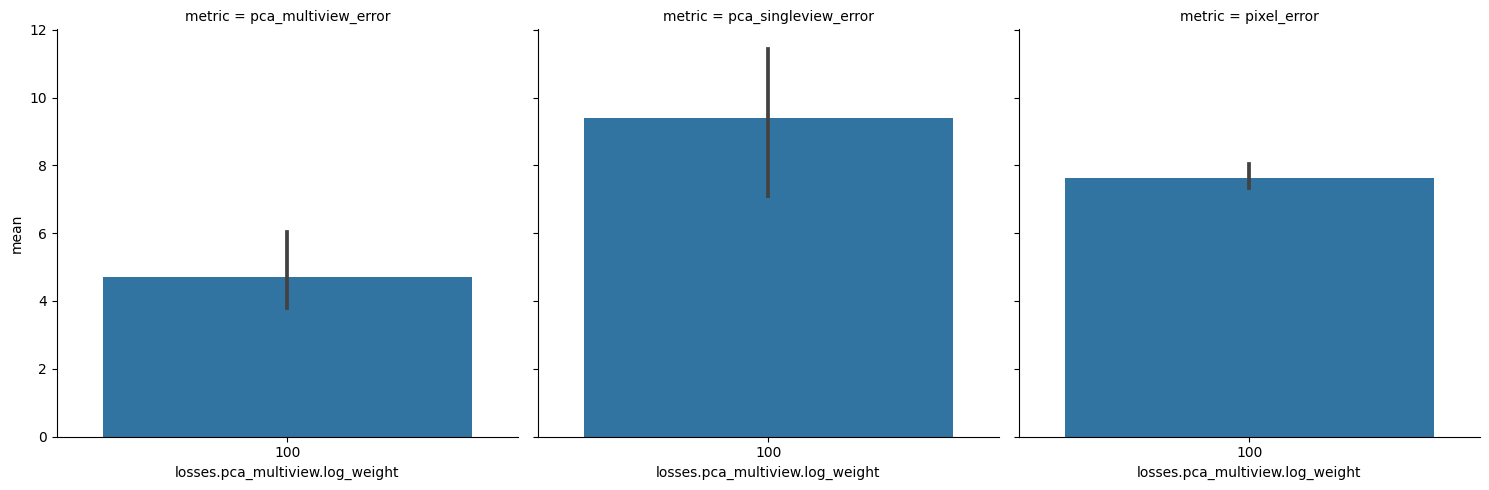

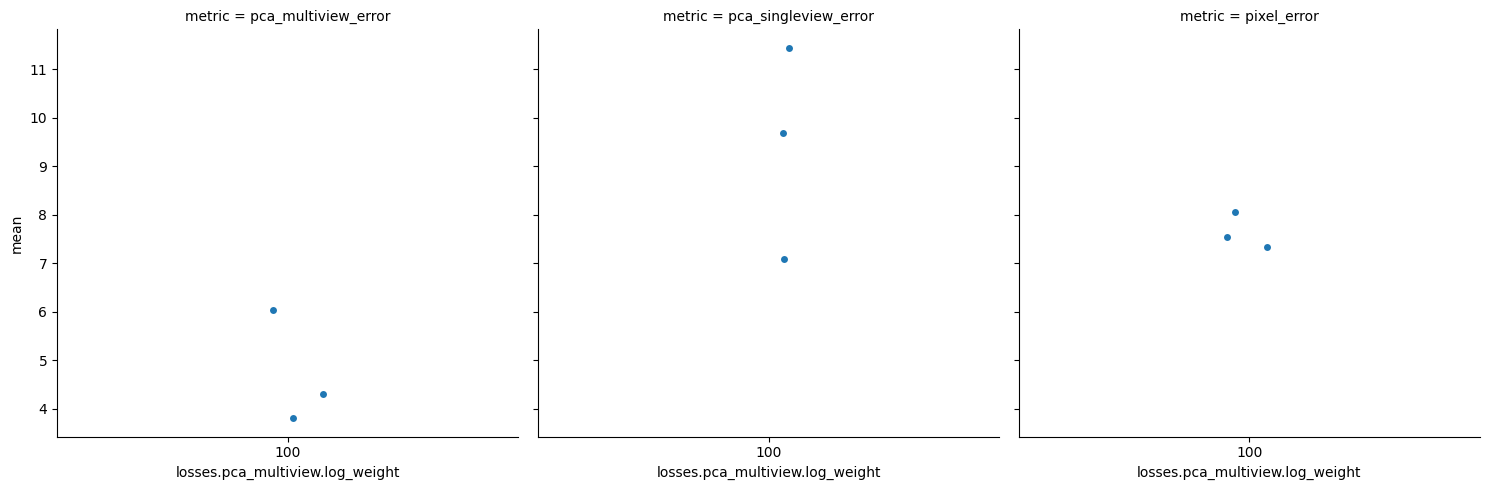

In [45]:
sns.catplot(data=df_big_mean[df_big_mean["set"] == split_set], x=hparam_name, order=values, y="mean", col="metric", errorbar=('ci', 95), kind="bar") # x="unimodal_mse_log_weight"
sns.catplot(data=df_big_mean[df_big_mean["set"] == split_set], x=hparam_name, order=values, y="mean", col="metric", errorbar=('ci', 95)) # x="unimodal_mse_log_weight"



In [43]:
# df_big_mean.columns
# print(df_big.columns)
df_big_mean.columns

Index(['rng_seed_data_pt', 'losses.pca_multiview.log_weight', 'metric', 'set',
       'paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top',
       'tailMid_top', 'nose_top', 'obs_top', 'paw1LH_bot', 'paw2LF_bot',
       'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot', 'tailMid_bot', 'nose_bot',
       'obsHigh_bot', 'obsLow_bot', 'mean'],
      dtype='object')

In [31]:
df_big.columns[df_big.columns.str.contains("set")]

Index(['set'], dtype='object')

In [44]:
df_big_mean.head()

,rng_seed_data_pt,losses.pca_multiview.log_weight,metric,set,paw1LH_top,paw2LF_top,paw3RF_top,paw4RH_top,tailBase_top,tailMid_top,...,paw1LH_bot,paw2LF_bot,paw3RF_bot,paw4RH_bot,tailBase_bot,tailMid_bot,nose_bot,obsHigh_bot,obsLow_bot,mean


In [ ]:
# in reality we always average over random seeds
# and we also average over all bodyparts
# then we have one number per index (and metric) which we can compute mean and std across

In [23]:
# builda a dataframe with the different metrics  for each model
pixel_error = pd.read_csv(os.path.join(total_df["path"].iloc[0], "predictions_pixel_error.csv"), header=[0], index_col=0)
pca_sv_error = pd.read_csv(os.path.join(total_df["path"].iloc[0], "predictions_pca_singleview_error.csv"), header=[0], index_col=0)
# concat dfs and add datasource 
# col1 col2 ... coln metric_name
pixel_error["metric_name"] = "pixel_error"
pixel_error
pca_sv_error["metric_name"] = "pca_sv_error"
metrics_df = pd.concat([pixel_error, pca_sv_error])
print(metrics_df.shape)
# metrics_df.head()
metrics_df.tail()


(1578, 18)


,paw1LH_top,paw2LF_top,paw3RF_top,paw4RH_top,tailBase_top,tailMid_top,nose_top,obs_top,paw1LH_bot,paw2LF_bot,paw3RF_bot,paw4RH_bot,tailBase_bot,tailMid_bot,nose_bot,obsHigh_bot,obsLow_bot,metric_name
labeled-data/180618_010/img015138.png,3.597447,9.845196,2.319927,5.746223,10.062808,6.068479,5.214673,NaN,2.713475,9.559510,3.589464,4.692842,3.156467,2.835987,4.193313,NaN,NaN,pca_sv_error
labeled-data/180618_010/img015239.png,1.040644,7.150720,1.202592,4.670954,6.687197,3.449102,5.656707,NaN,4.015197,6.924648,2.004379,4.508363,1.449139,7.106095,5.712533,NaN,NaN,pca_sv_error
labeled-data/180618_010/img015255.png,0.969156,1.107023,0.287090,0.386345,8.342234,3.844841,5.888730,NaN,1.731964,1.112309,0.606375,0.485698,3.845474,2.873000,6.867593,NaN,NaN,pca_sv_error
labeled-data/180618_010/img015256.png,8.874399,4.952618,0.695706,4.410593,9.027818,4.032358,5.565386,NaN,8.464097,3.961636,1.494496,4.269255,2.836296,4.759048,4.074685,NaN,NaN,pca_sv_error
labeled-data/180618_010/img015397.png,1.563273,0.466724,0.508362,1.632182,6.238623,2.623401,5.355439,NaN,2.383311,0.792233,0.083734,1.791323,5.436836,4.716587,5.487217,NaN,NaN,pca_sv_error


## what do we want to plot per sweep
- the mean and error bars are over rng seeds if these exist.
- we have cols per metric
- x axis is over the quantity we are sweeping over -- log weight? this has to be specified before plotting. 
- y axis is over the metric we are plotting (bodypart specific or mean over all bodyparts)
This is for selecting hparams, no need to dive into bodypart performance or scatter plots.

Text(0.5, 1.0, 'dataset: /Users/danbiderman/Dropbox/Columbia/1.Dan/Research/grid_artifacts/urban-chebyshev-5171/urban-chebyshev-5171-exp1/outputs/2022-11-15/15-55-27')

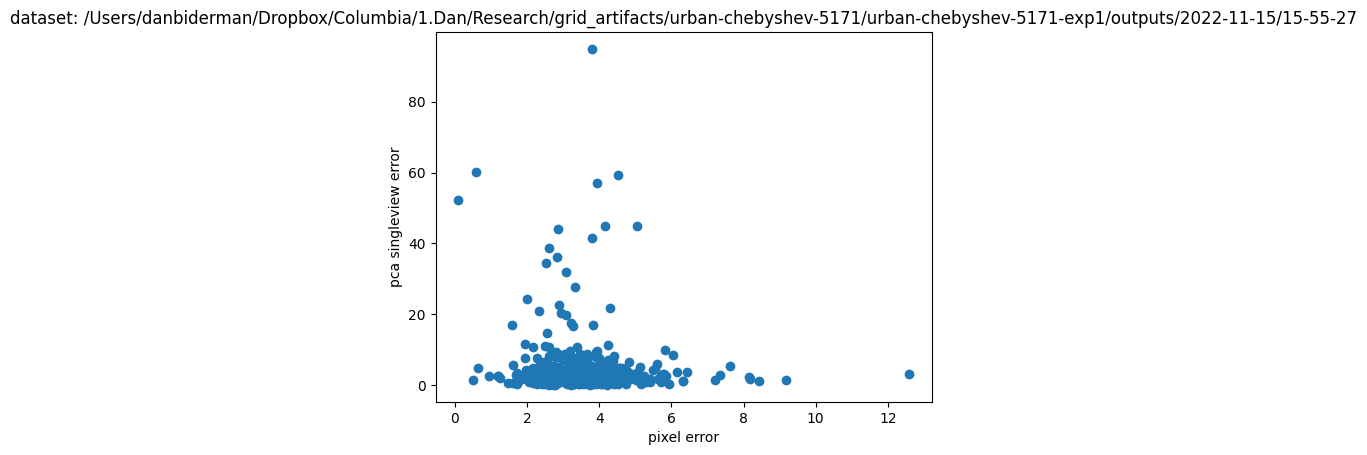

In [17]:
plt.scatter(pixel_error["paw1LH_bot"], pca_sv_error["paw1LH_bot"])
plt.xlabel("pixel error")
plt.ylabel("pca singleview error")
plt.title("dataset: %s" % total_df["path"].iloc[0])

In [9]:
# single combined query
query_1 = query_builder.combine_queries("and")
query_2 = "(`training.rng_seed_data_pt` == '1') or (`training.rng_seed_data_pt` == '2')"
print(query_1)
print(query_2)
combo = f"({query_1}) and ({query_2})"
print(combo)
print(total_df.query(combo))


(`model.losses_to_use` == '[]') and (timestamp >= '2022-11-14' and timestamp <= '2022-11-16')
(`training.rng_seed_data_pt` == '1') or (`training.rng_seed_data_pt` == '2')
((`model.losses_to_use` == '[]') and (timestamp >= '2022-11-14' and timestamp <= '2022-11-16')) and ((`training.rng_seed_data_pt` == '1') or (`training.rng_seed_data_pt` == '2'))
  data.image_orig_dims.height data.image_orig_dims.width  \
0                         406                        396   
0                         406                        396   
0                         406                        396   
0                         406                        396   

  data.image_resize_dims.height data.image_resize_dims.width  \
0                           256                          256   
0                           256                          256   
0                           256                          256   
0                           256                          256   

              data.data_dir 

In [6]:
total_df.query(query_builder.combine_queries("and"))

,data.image_orig_dims.height,data.image_orig_dims.width,data.image_resize_dims.height,data.image_resize_dims.width,data.data_dir,data.video_dir,data.csv_file,data.header_rows,data.downsample_factor,data.num_keypoints,...,eval.confidence_thresh_for_vid,eval.video_file_to_plot,eval.pred_csv_files_to_plot,callbacks.anneal_weight.attr_name,callbacks.anneal_weight.init_val,callbacks.anneal_weight.increase_factor,callbacks.anneal_weight.final_val,callbacks.anneal_weight.freeze_until_epoch,timestamp,path
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:30:09,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:42,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:32:33,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:30:36,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:18,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:55,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...


In [6]:
queried_df = total_df.query(query_builder.combine_queries("and"))

UndefinedVariableError: local variable 'value' is not defined

In [9]:
queried_df.shape

(6, 96)

In [37]:
print(queried_df.head()["path"].iloc[0])

/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/grid_artifacts/affable-lamport-279/affable-lamport-279-exp15/outputs/2022-07-15/15-28-21


In [8]:
# query if random seed is in list
filter_list = ["0","1","2"]
query = "(`training.rng_seed_data_pt` in @filter_list) and (`model.losses_to_use` == '[]')"
print(query)
total_df.query(query)
#total_df.query("`training.rng_seed_data_pt` in [1,2]")

(`training.rng_seed_data_pt` in @filter_list) and (`model.losses_to_use` == '[]')


,data.image_orig_dims.height,data.image_orig_dims.width,data.image_resize_dims.height,data.image_resize_dims.width,data.data_dir,data.video_dir,data.csv_file,data.header_rows,data.downsample_factor,data.num_keypoints,...,eval.create_labeled_video,eval.confidence_thresh_for_vid,eval.video_file_to_plot,eval.pred_csv_files_to_plot,callbacks.anneal_weight.attr_name,callbacks.anneal_weight.init_val,callbacks.anneal_weight.increase_factor,callbacks.anneal_weight.final_val,callbacks.anneal_weight.freeze_until_epoch,timestamp
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:30:09
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:42
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:32:33
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:30:36
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:18
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:55
